In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os 
from pathlib import Path
import uproot
import pandas as pd

In [ ]:
#Reading in Coincidences DF

coincidences_df = pd.read_csv("output/coincidences.csv")

Coincidence finding summary:
  Accepted pairs: 3887
  Rejected suspected multiple coincidences: 2


In [ ]:
#Defining the 3D Voxel grid

vox_size = 2 # Defining voxel size (mm)
volume_mm = (200, 200, 32)

voxDim = tuple(int(length / vox_size) for length in volume_mm) # (150, 150, 16)

voxel_grid = np.ones(voxDim, dtype=np.float32)
#print(voxel_grid)

voxel_origin_mm = np.array([ 
    -volume_mm[0] / 2 + vox_size, 
    -volume_mm[1] / 2 + vox_size,
    -volume_mm[2] / 2 + vox_size
]) #centres the voxel grid around (0, 0, 0) in world coordinates

time_threshold_ns = 0.7 #chose this because it should be the max time difference if a decay occurs at the circumference of the r = 100mm circle
#ensures only physically plausible pairs are considered

##Loop over LORs and find interesting voxels


In [14]:
def clip_lor_to_grid(p1, p2, origin, voxel_size, grid_shape):
    grid_min = origin
    grid_max = origin + np.array(grid_shape) * voxel_size
    direction = p2 - p1

    with np.errstate(divide='ignore', invalid='ignore'):
        tmin = (grid_min - p1) / direction
        tmax = (grid_max - p1) / direction

    t1 = np.minimum(tmin, tmax)
    t2 = np.maximum(tmin, tmax)

    t_enter = np.nanmax(t1)
    t_exit = np.nanmin(t2)

    if t_enter > t_exit or t_exit < 0 or t_enter > 1:
        return None, None  # no intersection

    # Clamp to [0, 1] range of original segment
    t0 = max(t_enter, 0)
    t1 = min(t_exit, 1)

    clipped_p1 = p1 + t0 * direction
    clipped_p2 = p1 + t1 * direction

    return clipped_p1, clipped_p2


In [15]:
#Function to sample along LOR - find out which voxels a LOR goes through and also weight it based on how much of the voxel it passes through

def get_voxel_indices(p1, p2, origin, voxel_size, grid_shape):

    '''This function computes which voxels the LOR intersects with and how far the LOR travels in each voxel'''

    #Convert the start and end points form mm into voxel space
    p1_voxel = (p1 - origin) / voxel_size
    p2_voxel = (p2 - origin) / voxel_size

    #Define LOR direction and total length
    direction = p2_voxel - p1_voxel
    length_total = np.linalg.norm(direction)
    if length_total == 0:
        return []
    
    #Normalise the direction 
    direction_unit = direction / length_total

    #Prepare voxel grid and start at the correct voxel 
    nx, ny, nz = grid_shape
    current_voxel = np.floor(p1_voxel).astype(int)

    voxels = []
    t_max = np.zeros(3)
    t_delta = np.zeros(3)
    step = np.zeros(3, dtype=int)

    for i in range(3):
        if direction_unit[i] > 0:
            step[i] = 1
            next_voxel_boundary = (current_voxel[i] + 1) * 1.0
        else:
            step[i] = -1
            next_voxel_boundary = current_voxel[i] * 1.0

        if direction_unit[i] != 0:
            t_max[i] = (next_voxel_boundary - p1_voxel[i]) / direction_unit[i]
            t_delta[i] = abs(1.0 / direction_unit[i])
        else:
            t_max[i] = np.inf
            t_delta[i] = np.inf
            
    t = 0.0
    while t <= length_total:
        i, j, k = current_voxel
        if 0 <= i < nx and 0 <= j < ny and 0 <= k < nz:
            t_next = min(t_max)
            path_length = (t_next - t) * np.linalg.norm(voxel_size * direction_unit)
            voxels.append((i, j, k, path_length))
        else:
            break  # outside grid

        # Advance to next voxel
        axis = np.argmin(t_max)
        t = t_max[axis]
        t_max[axis] += t_delta[axis]
        current_voxel[axis] += step[axis]

    return voxels



In [16]:
#Getting LOR list
lor_list = []

for _, row in coincidences_df.iterrows():
    p1 = np.array([row["PostPosition_X_1"], row["PostPosition_Y_1"], row["PostPosition_Z_1"]])
    p2 = np.array([row["PostPosition_X_2"], row["PostPosition_Y_2"], row["PostPosition_Z_2"]])
    lor_list.append((p1, p2))

In [17]:
#Creating an empty sensitivity map
measured_dat = np.zeros_like(voxel_grid)

for p1, p2 in lor_list:

    p1_clipped, p2_clipped = clip_lor_to_grid(p1, p2, voxel_origin_mm, vox_size, voxDim)
    if p1_clipped is None:
        continue
    voxels = get_voxel_indices(p1_clipped, p2_clipped, voxel_origin_mm, vox_size, voxDim)

    if voxels:  # only process if at least one voxel was hit
        for i, j, k, path_length in voxels:
            measured_dat[i, j, k] += path_length  # or += 1 if you want constant weight


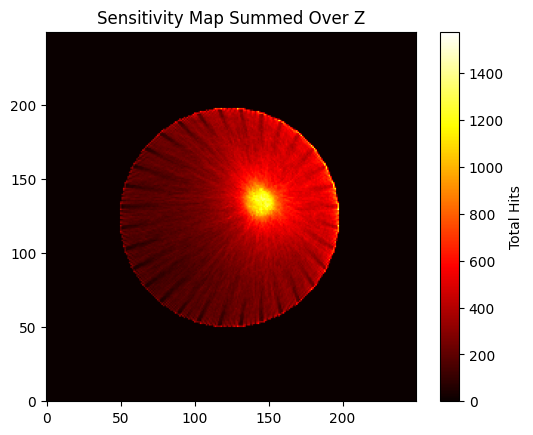

In [18]:
#Sensitivity map, shows how often voxel j is seen by all LORs

plt.imshow(np.sum(measured_dat, axis=2).T, cmap='hot', origin='lower')
plt.title("Sensitivity Map Summed Over Z")
plt.colorbar(label="Total Hits")

In [19]:
from scipy.ndimage import gaussian_filter

# --- Parameters ---
num_iterations = 10
epsilon = 1e-6  # small constant to avoid division by 0

# --- Initialize ---
image_estimate = np.ones_like(voxel_grid)
#image_estimate /= np.sum(image_estimate)  # Option A: normalize initial guess


for iteration in range(num_iterations):
    print(f"Starting iteration {iteration + 1}")
    numerator = np.zeros_like(voxel_grid)

    for p1, p2 in lor_list:

        p1_clipped, p2_clipped = clip_lor_to_grid(p1, p2, voxel_origin_mm, vox_size, voxDim)
        if p1_clipped is None:
            continue
        voxels = get_voxel_indices(p1_clipped, p2_clipped, voxel_origin_mm, vox_size, voxDim)

        if not voxels:
            continue

        forward_sum = sum(image_estimate[i, j, k] * l for (i, j, k, l) in voxels) + epsilon #forward project x^k
        measured_val = sum(measured_dat[i, j, k] * l for (i, j, k, l) in voxels)

        correction = measured_val / (forward_sum) # m / Ax^k

        for (i, j, k, l) in voxels: #backproject: A^T (1 / Ax^k)
            numerator[i, j, k] += correction * l

    ratio = numerator / (measured_dat + epsilon) #normalise: 1/A^T1 * A^T(1/Ax^k)
    image_estimate = image_estimate * ratio # getting x^(k+1)


Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7
Starting iteration 8
Starting iteration 9


KeyboardInterrupt: 

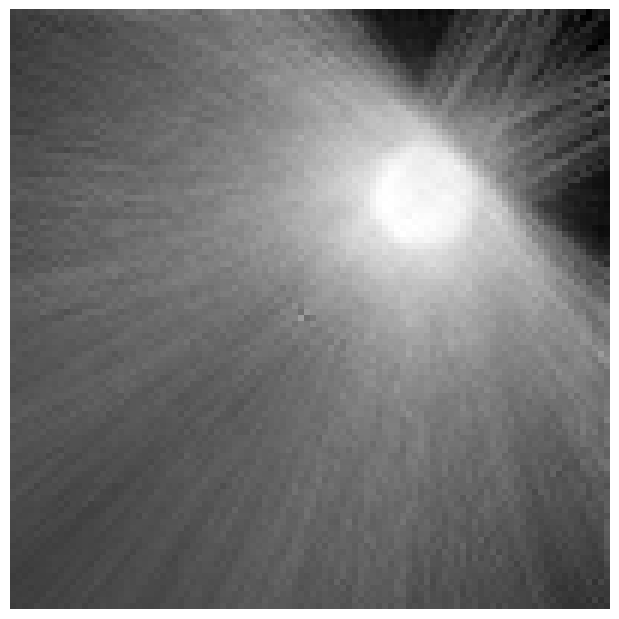

/var/folders/qv/434ty_nj1bdfm_6l1bc5ppg80000gn/T/ipykernel_69947/3187638220.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("image_estimate.png", dpi=300)
/var/folders/qv/434ty_nj1bdfm_6l1bc5ppg80000gn/T/ipykernel_69947/3187638220.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("image_estimate.png", dpi=300)
/var/folders/qv/434ty_nj1bdfm_6l1bc5ppg80000gn/T/ipykernel_69947/3187638220.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("image_estimate.png", dpi=300)
/var/folders/qv/434ty_nj1bdfm_6l1bc5ppg80000gn/T/ipykernel_69947/3187638220.py:13: MatplotlibDe

In [65]:
# Generate your final image array
projection_image = np.sum(image_estimate, axis=2)

# Plot it in a clean figure
fig = plt.figure(figsize=(6, 6), frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])  # Full canvas usage
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(projection_image.T, cmap='gray', origin='lower')
plt.show()

# Save the image-only output
fig.savefig("image_estimate.png", dpi=300)
plt.close(fig)
